In [1]:
#Assignment 4
#Anjali Kshirsagar
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense,LSTM,Dropout

In [2]:
!pip install yfinance tensorflow scikit-learn matplotlib

DEPRECATION: Loading egg at c:\users\anjuk\desktop\new folder\lib\site-packages\vboxapi-1.0-py3.11.egg is deprecated. pip 23.3 will enforce this behaviour change. A possible replacement is to use pip for package installation..


In [3]:
import yfinance as yf

In [4]:
# Step 1: Download data with adjusted close prices
data = yf.download('GOOG', start='2015-01-01', auto_adjust=False)
data.reset_index(inplace=True)

[*********************100%***********************]  1 of 1 completed


In [5]:
data.head()

Price,Date,Adj Close,Close,High,Low,Open,Volume
Ticker,,GOOG,GOOG,GOOG,GOOG,GOOG,GOOG
0,2015-01-02,26.045290,26.168653,26.490770,26.133251,26.378078,28951268
1,2015-01-05,25.502361,25.623152,26.144720,25.582764,26.091366,41196796
2,2015-01-06,24.911293,25.029282,25.738087,24.983908,25.679497,57998800
3,2015-01-07,24.868610,24.986401,25.292759,24.914099,25.280592,41301082
4,2015-01-08,24.947023,25.065184,25.105074,24.482782,24.831326,67071641


In [13]:
# Step 2: Preprocessing
# Use only the 'Close' column
close_data = data["Close"].values.reshape(-1, 1)

In [14]:
# Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(close_data)

In [16]:
print(scaled_data[:10])

[[0.00878288]
 [0.00580443]
 [0.0025619 ]
 [0.00232777]
 [0.00275792]
 [0.00098556]
 [0.        ]
 [0.00098828]
 [0.00226515]
 [0.00251562]]


In [13]:
# Split into training and test sets (80% training)
training_data_len = int(len(scaled_data) * 0.8)
train_data = scaled_data[:training_data_len]
test_data = scaled_data[training_data_len - 60:]  # last 60 for timestep continuity

In [14]:
# Step 3: Create training sequences
X_train, y_train = [], []
for i in range(60, len(train_data)):
    X_train.append(train_data[i - 60:i, 0])
    y_train.append(train_data[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [15]:
# Step 4: Build the LSTM model
model = Sequential([
    LSTM(100, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    LSTM(100, return_sequences=True),
    Dropout(0.2),
    LSTM(100, return_sequences=True),
    Dropout(0.2),
    LSTM(100),
    Dropout(0.2),
    Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')

C:\Users\anjuk\Desktop\New folder\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [16]:
# Step 5: Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=2)

Epoch 1/20
63/63 - 20s - 322ms/step - loss: 0.0055
Epoch 2/20
63/63 - 11s - 177ms/step - loss: 0.0011
Epoch 3/20
63/63 - 21s - 329ms/step - loss: 0.0011
Epoch 4/20
63/63 - 10s - 157ms/step - loss: 0.0013
Epoch 5/20
63/63 - 10s - 163ms/step - loss: 0.0011
Epoch 6/20
63/63 - 11s - 171ms/step - loss: 8.3653e-04
Epoch 7/20
63/63 - 12s - 183ms/step - loss: 8.6432e-04
Epoch 8/20
63/63 - 11s - 169ms/step - loss: 8.6016e-04
Epoch 9/20
63/63 - 10s - 159ms/step - loss: 8.8116e-04
Epoch 10/20
63/63 - 11s - 177ms/step - loss: 8.1982e-04
Epoch 11/20
63/63 - 12s - 192ms/step - loss: 7.6761e-04
Epoch 12/20
63/63 - 12s - 189ms/step - loss: 7.7366e-04
Epoch 13/20
63/63 - 11s - 180ms/step - loss: 8.4669e-04
Epoch 14/20
63/63 - 12s - 183ms/step - loss: 8.2846e-04
Epoch 15/20
63/63 - 11s - 178ms/step - loss: 6.9885e-04
Epoch 16/20
63/63 - 11s - 176ms/step - loss: 8.0370e-04
Epoch 17/20
63/63 - 12s - 197ms/step - loss: 5.8209e-04
Epoch 18/20
63/63 - 12s - 194ms/step - loss: 6.6069e-04
Epoch 19/20
63/63 - 1

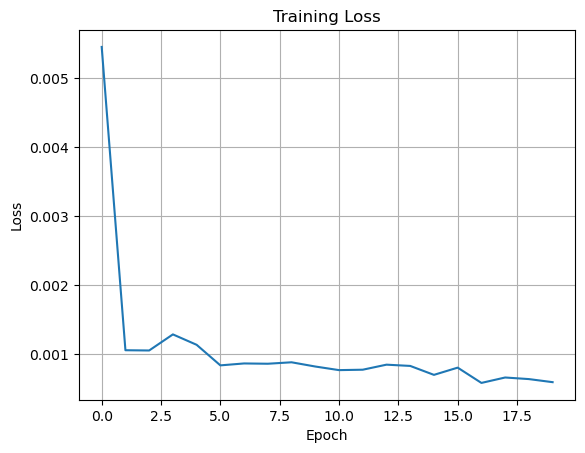

In [17]:
# Plot training loss
plt.plot(history.history['loss'])
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

In [18]:
# Step 6: Prepare test sequences
X_test = []
for i in range(60, len(test_data)):
    X_test.append(test_data[i - 60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [19]:
# Step 7: Make predictions
predicted_prices = model.predict(X_test)
predicted_prices = scaler.inverse_transform(predicted_prices)

17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 220ms/step


In [20]:
# Actual prices for comparison
actual_prices = scaler.inverse_transform(test_data[60:])

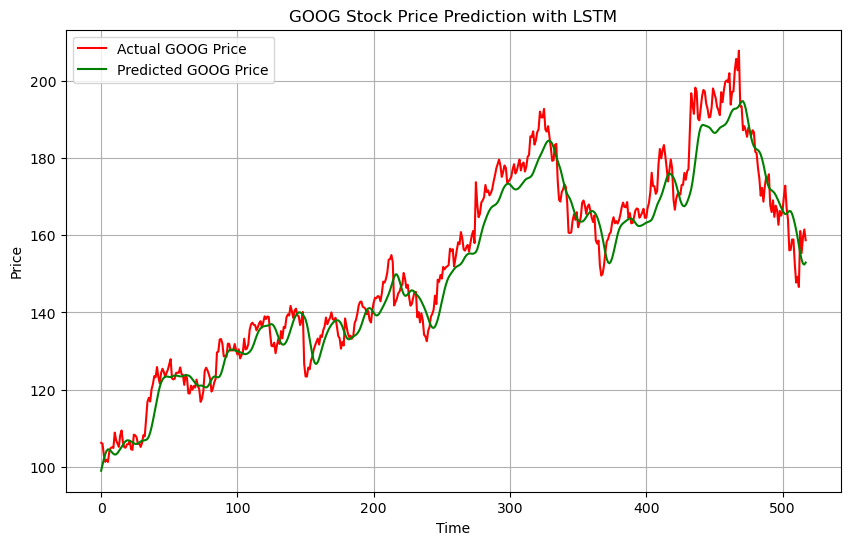

In [21]:
# Step 8: Visualize results
plt.figure(figsize=(10, 6))
plt.plot(actual_prices, color='red', label='Actual GOOG Price')
plt.plot(predicted_prices, color='green', label='Predicted GOOG Price')
plt.title('GOOG Stock Price Prediction with LSTM')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()